In [33]:
 !pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in c:\users\fedeb\desktop\datos\workspace\venv\lib\site-packages (0.24.1)


You should consider upgrading via the 'c:\users\fedeb\desktop\datos\workspace\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [34]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datos_2c2020_tp2.models.log.Logger as logger

In [35]:
train = pd.read_csv("../datasets/xgb-train.csv")
test = pd.read_csv("../datasets/xgb-test.csv")

In [36]:
# train['Week_Day'].describe()

# TP2 - XGBoost Binary Classifier


Luego verifico que dropear filas que se overlapean con test implica
dejar de lado la mayoria de datos por lo cual no se tendraa en cuenta.
(djo el codigo de dropeo comentaado)

-----------------------------------------


# Seteo de features

In [37]:
target = "target"
features = list(train.columns)
features.remove(target)
features.remove("Opportunity_ID")

#VANILLA NO
# features.remove("delivery_delay")
# features.remove("opportunity_lifetime")
# features.remove("converted_taxable_amount")
# features.remove("last_modified_to_delivery")
# features.remove("currency_conversion_rate")
# features.remove("Occur")
# features.remove("delivery_window")
# features.remove("account_creation_to_created_opp")

#VANILLA SI
features.remove('Total_Taxable_Amount')
features.remove('ASP_(converted)')
features.remove("ASP")
features.remove("Total_Amount")
features.remove("Delivery_Year")
# features.remove("Week_Day")

#CONSIDERO REMOVIBLES
# features.remove("created_blocknum")   #FECHA!!
features.remove("quote_blocknum")
features.remove("late_delivery_blocknum")
features.remove("early_delivery_blocknum")
features.remove("last_modified_blocknum")
# features.remove("account_creation_blocknum") #OJO CCON HIPOTESIS DEL CLIENTE VIEEJO
print("Features totales: {}".format(len(features)))



Features totales: 113


# Armado de sets
FORMAS:

In [38]:
X_train, y_train = train.loc[:,features], train.loc[:,target]
X_test_Opp = test.loc[:,"Opportunity_ID"]
X_test = test.loc[:,features]

print("Set de entrenamiento (size) {}".format(X_train.shape))
print("Set de testing (size) {}".format(X_test.shape))

Set de entrenamiento (size) (16947, 113)
Set de testing (size) (2551, 113)


Por otra parte seepaaro el test de entrenamiento en aprox~(80%/20%) segun la fecha de creeacion de la oportunidad.

In [39]:
percent_80 = train["created_blocknum"].describe()['75%']/0.945
beta_test = train[train["created_blocknum"]>percent_80]
beta_train = train[train["created_blocknum"]<percent_80]


In [40]:
A_train, b_train = beta_train.loc[:,features], beta_train.loc[:,target]
# A_test_Opp = beta_test.loc[:,"Opportunity_ID"]
A_test, b_test = beta_test.loc[:,features], beta_test.loc[:,target]

print("Set de entrenamiento secundario (size) {}".format(A_train.shape))
print("Set de testing secundario (size) {}".format(A_test.shape))

Set de entrenamiento secundario (size) (14078, 113)
Set de testing secundario (size) (2869, 113)


In [41]:

dtrain = xgb.DMatrix(X_train, label=y_train)



# Tuneo de hiperparametros
* GRIDSEARCH + CROSS VALIDATION

Configuracion

In [42]:
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------
#----------------------------- C O N F I G U R A C I O N ----------------------------------
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------

nfolds = 5
rounds = 200
boost_rounds = 150
early_stopping_rounds = 6

params = {"objective": "binary:logistic",
          'colsample_bytree': 0.3,
          'subsample': 1.0,
          'learning_rate': 0.1,
          'max_depth': 6,
          'min_child_weight': 1,
          'eval_metric': 'logloss'}
beta_params = params.copy()
beta_params['n_estimators'] = 100


enaable_gridsearch_for_tree = True
enaable_gridsearch_for_sampling = True
enaable_gridsearch_for_learning = True
final_cv = False
enable_parcial_training = True

print("Usando nfolds={},  num_boost_round={}"
      "  y  early_stopping_rounds={}".format(nfolds, rounds, early_stopping_rounds))

#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------

Usando nfolds=5,  num_boost_round=200  y  early_stopping_rounds=6


In [43]:
#FUNCIONES

def find_best_param_tuple(dtrain, params, param_tuple):
    # Define initial best params and LogLoss
    min_logloss = float("Inf")
    best_params = None
    for param0, param1 in param_tuple['grid']:
        print("CV with {}={}, {}={}".format(param_tuple['names'][0],
                                 param0,
                                 param_tuple['names'][1],
                                 param1))
        # Update our parameters
        params[param_tuple['names'][0]] = param0
        if param_tuple['names'][1]: params[param_tuple['names'][1]] = param1
        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=rounds,
            seed=1234,
            nfold=nfolds,
            metrics='logloss',
            early_stopping_rounds=early_stopping_rounds
        )
        # Update best LogLoss
        mean_logloss = cv_results['test-logloss-mean'].min()
        current_boost_rounds = cv_results['test-logloss-mean'].argmin()+1
        print("\tLL {} for {} rounds".format(mean_logloss, current_boost_rounds))
        if mean_logloss < min_logloss:
            min_logloss = mean_logloss
            best_params = (param0, param1)
            global boost_rounds
            boost_rounds = current_boost_rounds
    print("Best {},{}: {}, {}, LogLoss: {}".format(param_tuple['names'][0],param_tuple['names'][1],best_params[0], best_params[1], min_logloss))
    return best_params

TUNEO DE:
* max_depth
* min_child_weight

In [44]:
if enaable_gridsearch_for_tree:

    tree_params_tuple = {
        'names': ('max_depth', 'min_child_weight'),
        'grid': [
            (max_depth, min_child_weight)
            for max_depth in range(5,14,1)
            for min_child_weight in range(1,2)
        ]
    }

    best_tree_params = find_best_param_tuple(dtrain, params, tree_params_tuple)

    params['max_depth'] = best_tree_params[0]
    params['min_child_weight'] = best_tree_params[1]

CV with max_depth=5, min_child_weight=1
	LL 0.21869119999999995 for 200 rounds
CV with max_depth=6, min_child_weight=1
	LL 0.19584580000000001 for 200 rounds
CV with max_depth=7, min_child_weight=1
	LL 0.1782392 for 200 rounds
CV with max_depth=8, min_child_weight=1
	LL 0.16629139999999998 for 200 rounds
CV with max_depth=9, min_child_weight=1
	LL 0.16225260000000002 for 199 rounds
CV with max_depth=10, min_child_weight=1
	LL 0.1605566 for 200 rounds
CV with max_depth=11, min_child_weight=1
	LL 0.1594962 for 179 rounds
CV with max_depth=12, min_child_weight=1
	LL 0.15803799999999998 for 155 rounds
CV with max_depth=13, min_child_weight=1
	LL 0.1592134 for 158 rounds
Best max_depth,min_child_weight: 12, 1, LogLoss: 0.15803799999999998


TUNEO DE:
* subsamble
* colsample_bytree


In [45]:
if enaable_gridsearch_for_sampling:

    sample_params_tuple = {
        'names': ('subsample', 'colsample_bytree'),
        'grid': [
            (subsample, colsample_bytree)
            for subsample in [i/10. for i in range(7,11)]
            for colsample_bytree in  [i/10. for i in range(2,5)]
        ]
    }

    best_sample_params = find_best_param_tuple(dtrain, params, sample_params_tuple)

    params['subsample'] = best_sample_params[0]
    params['colsample_bytree'] = best_sample_params[1]

CV with subsample=0.7, colsample_bytree=0.2
	LL 0.1634658 for 200 rounds
CV with subsample=0.7, colsample_bytree=0.3
	LL 0.16405940000000002 for 167 rounds
CV with subsample=0.7, colsample_bytree=0.4
	LL 0.16470880000000002 for 168 rounds
CV with subsample=0.8, colsample_bytree=0.2
	LL 0.16185460000000002 for 200 rounds
CV with subsample=0.8, colsample_bytree=0.3
	LL 0.1608562 for 166 rounds
CV with subsample=0.8, colsample_bytree=0.4
	LL 0.164962 for 126 rounds
CV with subsample=0.9, colsample_bytree=0.2
	LL 0.15996500000000002 for 198 rounds
CV with subsample=0.9, colsample_bytree=0.3
	LL 0.1603668 for 169 rounds
CV with subsample=0.9, colsample_bytree=0.4
	LL 0.16164420000000002 for 145 rounds
CV with subsample=1.0, colsample_bytree=0.2
	LL 0.1581974 for 182 rounds
CV with subsample=1.0, colsample_bytree=0.3
	LL 0.15803799999999998 for 155 rounds
CV with subsample=1.0, colsample_bytree=0.4
	LL 0.1612784 for 126 rounds
Best subsample,colsample_bytree: 1.0, 0.3, LogLoss: 0.15803799999

TUNEO DE:
* learning rate (eta)

In [46]:
if enaable_gridsearch_for_learning:
    learning_rate_grid = [
        (learning_rate, empty)
        for learning_rate in [i/100. for i in range(5,21)]
        for empty in range(1,2)
    ]
    learning_rate = {
        'names': ('learning_rate',''),
        'grid': learning_rate_grid,
    }
    params['learning_rate'] = find_best_param_tuple(dtrain, params, learning_rate)[0]

CV with learning_rate=0.05, =1
	LL 0.1614324 for 200 rounds
CV with learning_rate=0.06, =1
	LL 0.15868900000000002 for 200 rounds
CV with learning_rate=0.07, =1
	LL 0.1577054 for 200 rounds
CV with learning_rate=0.08, =1
	LL 0.15787559999999998 for 192 rounds
CV with learning_rate=0.09, =1
	LL 0.15828 for 173 rounds
CV with learning_rate=0.1, =1
	LL 0.15803799999999998 for 155 rounds
CV with learning_rate=0.11, =1
	LL 0.1588998 for 147 rounds
CV with learning_rate=0.12, =1
	LL 0.1593016 for 129 rounds
CV with learning_rate=0.13, =1
	LL 0.15919560000000002 for 123 rounds
CV with learning_rate=0.14, =1
	LL 0.1616588 for 101 rounds
CV with learning_rate=0.15, =1
	LL 0.1614588 for 112 rounds
CV with learning_rate=0.16, =1
	LL 0.1620624 for 101 rounds
CV with learning_rate=0.17, =1
	LL 0.1647888 for 88 rounds
CV with learning_rate=0.18, =1
	LL 0.16381300000000001 for 86 rounds
CV with learning_rate=0.19, =1
	LL 0.16536659999999997 for 86 rounds
CV with learning_rate=0.2, =1
	LL 0.1623117999

Final cross validation error

In [47]:
if final_cv:
    cv_results = xgb.cv(
                params,
                dtrain,
                num_boost_round=1000,
                seed=1234,
                nfold=len(features),
                metrics='logloss',
                early_stopping_rounds=early_stopping_rounds
            )
    print("Rounds    LogLoss \n  {}.".format(cv_results["test-logloss-mean"].tail(1), cv_results["test-logloss-mean"].tail(1)))
    display(cv_results.tail(1))

# Entrenamiento

In [48]:
xgb_clf = xgb.XGBClassifier(objective ='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            colsample_bytree = params['colsample_bytree'],
            subsample = params['subsample'],
            learning_rate = params['learning_rate'],
            max_depth = params['max_depth'],
            n_estimators = boost_rounds,
            reg_alpha=0,
            min_child_weight = params['min_child_weight'])


xgb_clf.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.07, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [49]:
preds = [pred[1] for pred in xgb_clf.predict_proba(X_test)]
# preds

# ENTRENAMIENTO PARCIAL
CALCULO DE ERROR EN BASE A PARTICION DE SET DE ENTRENAMIENTO POR FECHA DE CREACION DE LA OPORTUNIDAD

In [50]:
def partial_tune(params, params_to_tune):
    min_logloss = float("Inf")
    max_accuracy = -float("Inf")
    best_params = None
    for param0, param1 in params_to_tune['range']:
        print("{}={}, {}={}".format(params_to_tune['names'][0],
                                    param0,
                                    params_to_tune['names'][1],
                                    param1))
        # Update our parameters
        params[params_to_tune['names'][0]] = param0
        params[params_to_tune['names'][1]] = param1
        # Run CV
        beta_xgb_clf = xgb.XGBClassifier(objective ='binary:logistic', eval_metric='logloss', use_label_encoder=False,
                    colsample_bytree = params['colsample_bytree'],
                    subsample = params['subsample'],
                    learning_rate = params['learning_rate'],
                    max_depth = int(params['max_depth']),
                    n_estimators = params['n_estimators'],
                    reg_alpha=params['alpha'],
                    min_child_weight = params['min_child_weight'])
        beta_xgb_clf.fit(A_train,b_train)
        beta_preds = [pred[1] for pred in beta_xgb_clf.predict_proba(A_test)]
        print("Log loss: {}".format(log_loss(b_test, beta_preds)))

        predictions = [round(value) for value in beta_preds]
        accuracy = accuracy_score(b_test, predictions)
        print("Accuracy: %.2f%%" % (accuracy * 100.0))

        # Update best LogLoss
        mean_logloss = log_loss(b_test, beta_preds)
        if mean_logloss < min_logloss:
            min_logloss = mean_logloss
            best_params = (param0, param1)
        if max_accuracy < accuracy:
            max_accuracy = accuracy
            best_acu_params = (param0, param1)
    print("Best {}: ({}, {}) with LogLoss: {}".format(params_to_tune['names'], best_params[0], best_params[1], min_logloss))
    print("Best {}: ({}, {}) with Accu: {}".format(params_to_tune['names'], best_acu_params[0], best_acu_params[1], max_accuracy))
    return best_params

#-----------------------------------
#-----------------------------------
#-----------------------------------

In [51]:
def beta_tune():
    print("\n TUNEANDO alpha \n")
    aplha_range = [
        (alpha, n_estimator)
        for alpha in range(0,11,2)
        for n_estimator in range(1,2)
    ]
    best_alpha = partial_tune(beta_params, {'names':('alpha',''),'range':aplha_range})
    beta_params['alpha'] = best_alpha[0]
    # beta_params['n_estimators'] = best_alpha[1]


    print("\n TUNEANDO learning_rate \n")
    learning_rate_range = [
        (learning_rate, empty)
        for learning_rate in [i/100. for i in range(8,21)]
        for empty in range(1,2)
    ]
    best_learning_rate = partial_tune(beta_params, {'names':('learning_rate',''),'range':learning_rate_range})
    beta_params['learning_rate'] = best_learning_rate[0]


    print("\n TUNEANDO TREE_PARAMS \n")
    tree_params_range = [
        (max_depth, min_child_weight)
        for max_depth in range(5,9)
        for min_child_weight in range(1,5)
    ]
    best_tree_params = partial_tune(beta_params, {'names':('max_depth','min_child_weight'),'range':tree_params_range})
    beta_params['max_depth'] = int(best_tree_params[0])
    beta_params['min_child_weight'] = int(best_tree_params[1])


    print("\n TUNEANDO sample_params \n")
    sample_grid_params = [
        (subsample, colsample_bytree)
        for subsample in [i/10. for i in range(6,11)]
        for colsample_bytree in  [i/10. for i in range(1,5)]
    ]
    best_sample_params = partial_tune(beta_params, {'names':('subsample','colsample_bytree'),'range':sample_grid_params})
    beta_params['subsample'] = best_sample_params[0]
    beta_params['colsample_bytree'] = best_sample_params[1]


    print("\n TUNEANDO n_estimators \n")
    n_estimator_range = [
        (n_estimator, empty)
        for n_estimator in range(120,140,1)
        for empty in range(1,2)
    ]
    best_n_estimator = partial_tune(beta_params, {'names':('n_estimators',''),'range':n_estimator_range})
    beta_params['n_estimators'] = best_n_estimator[0]

In [52]:
if enable_parcial_training:
    beta_tune()
    beta_tune()
    # beta_tune()




 TUNEANDO alpha 

alpha=0, =1
Log loss: 0.30344191007094967
Accuracy: 86.75%
alpha=2, =1
Log loss: 0.30567716415855467
Accuracy: 86.75%
alpha=4, =1
Log loss: 0.3109330587377483
Accuracy: 86.06%
alpha=6, =1
Log loss: 0.3227550880388613
Accuracy: 85.95%
alpha=8, =1
Log loss: 0.3258768893119679
Accuracy: 86.06%
alpha=10, =1
Log loss: 0.3331285259698097
Accuracy: 85.64%
Best ('alpha', ''): (0, 1) with LogLoss: 0.30344191007094967
Best ('alpha', ''): (0, 1) with Accu: 0.8675496688741722

 TUNEANDO learning_rate 

learning_rate=0.08, =1
Log loss: 0.31067823863581134
Accuracy: 87.17%
learning_rate=0.09, =1
Log loss: 0.3077336191692324
Accuracy: 87.21%
learning_rate=0.1, =1
Log loss: 0.30344191007094967
Accuracy: 86.75%
learning_rate=0.11, =1
Log loss: 0.3016087774654327
Accuracy: 87.07%
learning_rate=0.12, =1
Log loss: 0.29466382535177127
Accuracy: 87.56%
learning_rate=0.13, =1
Log loss: 0.2987372105318553
Accuracy: 87.91%
learning_rate=0.14, =1
Log loss: 0.2945868794043376
Accuracy: 86.89%


In [53]:
beta_xgb_clf = xgb.XGBClassifier(objective ='binary:logistic',
                                eval_metric='logloss',
                                use_label_encoder=False,
                                colsample_bytree = beta_params['colsample_bytree'],
                                subsample = beta_params['subsample'],
                                learning_rate = beta_params['learning_rate'],
                                max_depth = int(beta_params['max_depth']),
                                n_estimators = beta_params['n_estimators'],
                                reg_alpha=beta_params['alpha'],
                                min_child_weight = beta_params['min_child_weight'])
print(beta_xgb_clf)
beta_xgb_clf.fit(X_train,y_train)
beta_preds = [pred[1] for pred in beta_xgb_clf.predict_proba(X_test)]
beta_pred_df = pd.DataFrame(X_test_Opp)
beta_pred_df["Target"] = beta_preds
beta_pred_df = beta_pred_df.drop_duplicates("Opportunity_ID")
beta_pred_df.to_csv("../submits/xgb-clf-tunned-beta.csv", index=False)
display(beta_pred_df)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.3,
              eval_metric='logloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.14, max_delta_step=None, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=127, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=0, reg_lambda=None,
              scale_pos_weight=None, subsample=0.8, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)


,Opportunity_ID,Target
0,10689,0.979048
3,10690,0.686194
8,10691,0.271285
9,10692,0.277032
15,10693,0.988002
...,...,...
2545,12364,0.990097
2547,12365,0.117171
2548,12366,0.086925
2549,12367,0.863993


Guardando las predicciones a CSV

In [54]:
pred_df = pd.DataFrame(X_test_Opp)
pred_df["Target"] = preds
pred_df = pred_df.drop_duplicates("Opportunity_ID")
display(pred_df)
pred_df.to_csv("../submits/xgb-clf-cv_tunned.csv",index=False)

,Opportunity_ID,Target
0,10689,0.966011
3,10690,0.470794
8,10691,0.702523
9,10692,0.274790
15,10693,0.979814
...,...,...
2545,12364,0.987368
2547,12365,0.278091
2548,12366,0.201120
2549,12367,0.788826


{'objective': 'binary:logistic', 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.07, 'max_depth': 12, 'min_child_weight': 1, 'eval_metric': 'logloss'}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

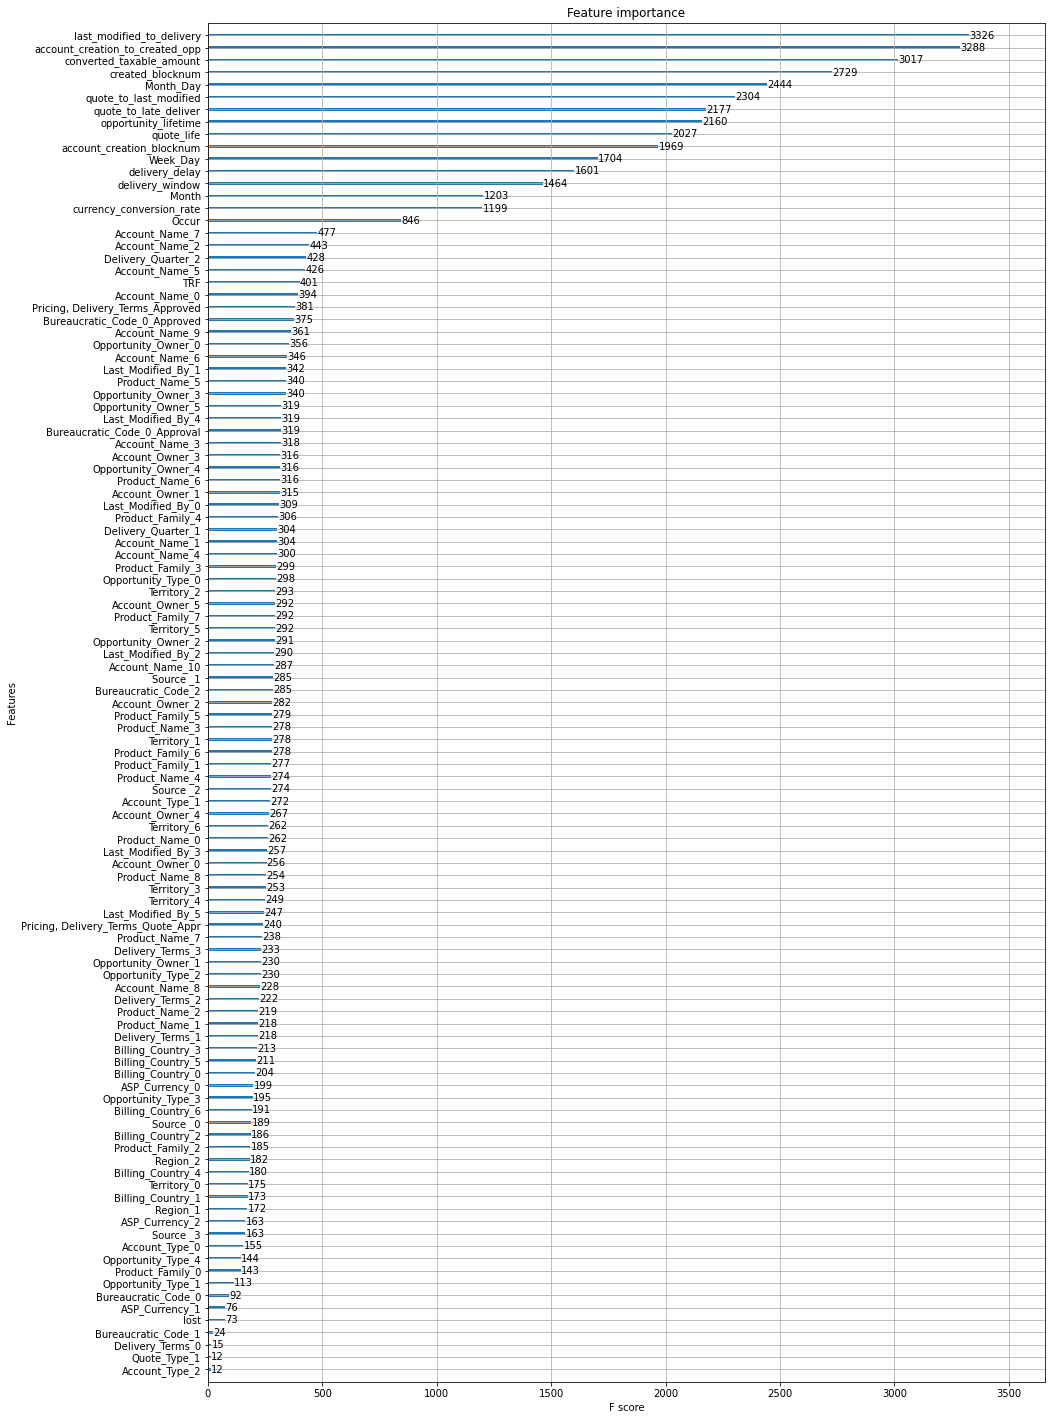

In [55]:
print(params)
plt.rcParams['figure.figsize'] = [15, 25]
xgb.plot_importance(xgb_clf)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

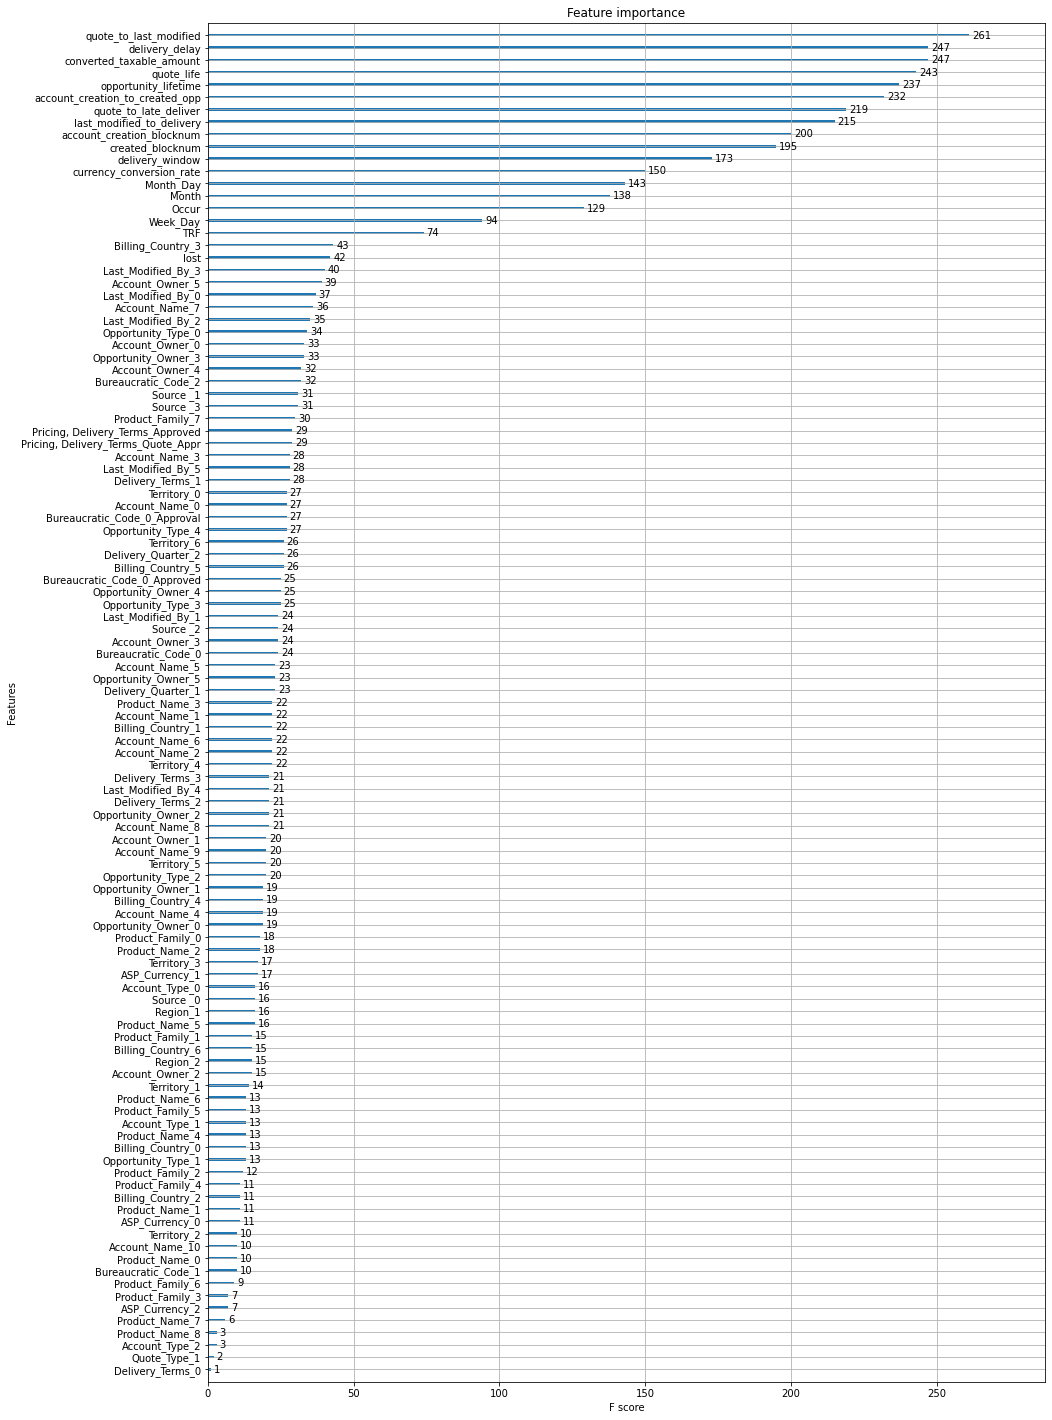

In [56]:
plt.rcParams['figure.figsize'] = [15, 25]
xgb.plot_importance(beta_xgb_clf)

In [57]:
# logger.Logger.log_model("xgb-logloss", params, features, cv_score)